# How to recover a known planet in Kepler data?

This tutorial demonstrates the basic steps required to recover a transiting planet candidate in the Kepler data.

We will show how you can recover the signal of [Kepler-10b](https://en.wikipedia.org/wiki/Kepler-10b), the first rocky planet that was discovered by Kepler! Kepler-10 is a Sun-like (G-type) star approximately 600 light years away in the constellation of Cygnus. In this tutorial, we will download the pixel data of Kepler-10, extract a lightcurve, and recover the planet.

Kepler pixel data is distributed in  "Target Pixel Files". You can read more about them in our tutorial [here](http://lightkurve.keplerscience.org/tutorials/target-pixel-files.html). The `lightkurve` package provides a `KeplerTargetPixelFile` class, which enables you to load and interact with data in this format.

The class can take a path (local or url), or you can load data straight from the [MAST archive](https://archive.stsci.edu/kepler/), which holds all of the Kepler and K2 data archive. We'll download the Kepler-10 light curve using the `from_archive` function, as shown below. *(Note: we're adding the keyword `quarter=3` to download only the data from the third Kepler quarter. There were 17 quarters during the Kepler mission.)*

In [1]:
from lightkurve import search_targetpixelfile
tpf = search_targetpixelfile("Kepler-10", quarter=3).download()

Let's use the `plot` method and pass along an aperture mask and a few plotting arguments.

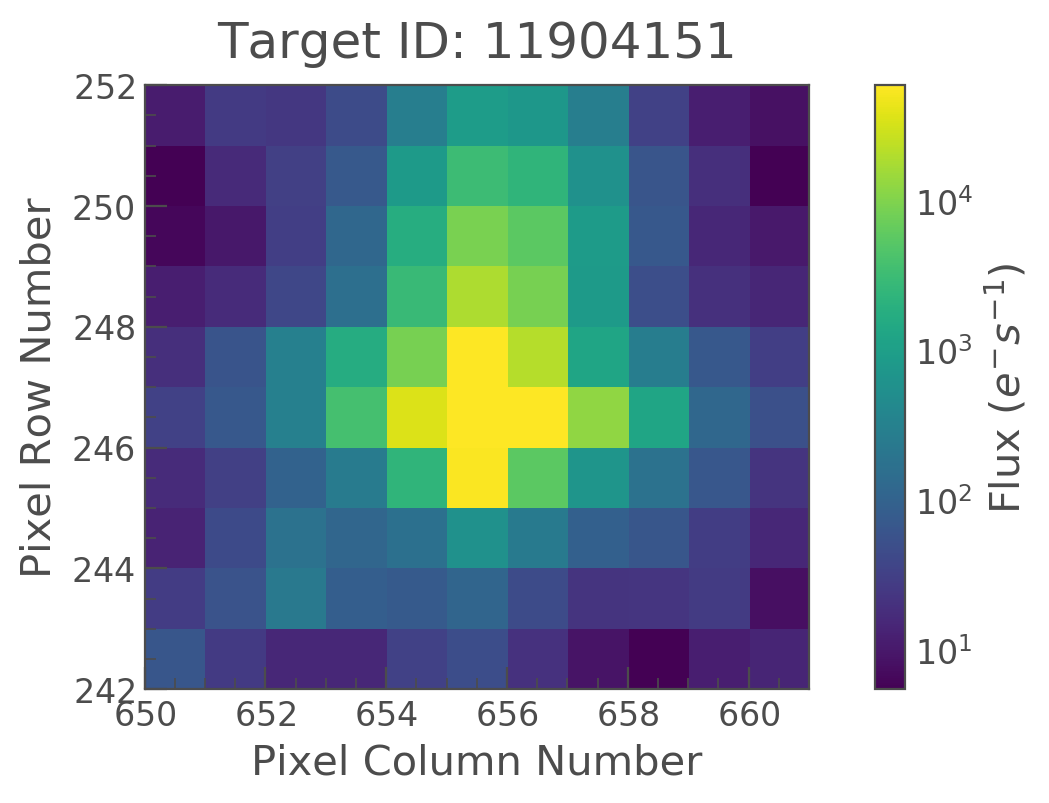

In [2]:
tpf.plot(scale='log');

The target pixel file contains one bright star with approximately 50,000 counts.

Now, we will use the ``to_lightcurve`` method to create a simple aperture photometry lightcurve using the
mask defined by the pipeline which is stored in `tpf.pipeline_mask`.

In [3]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

Let's take a look at the output lightcurve.

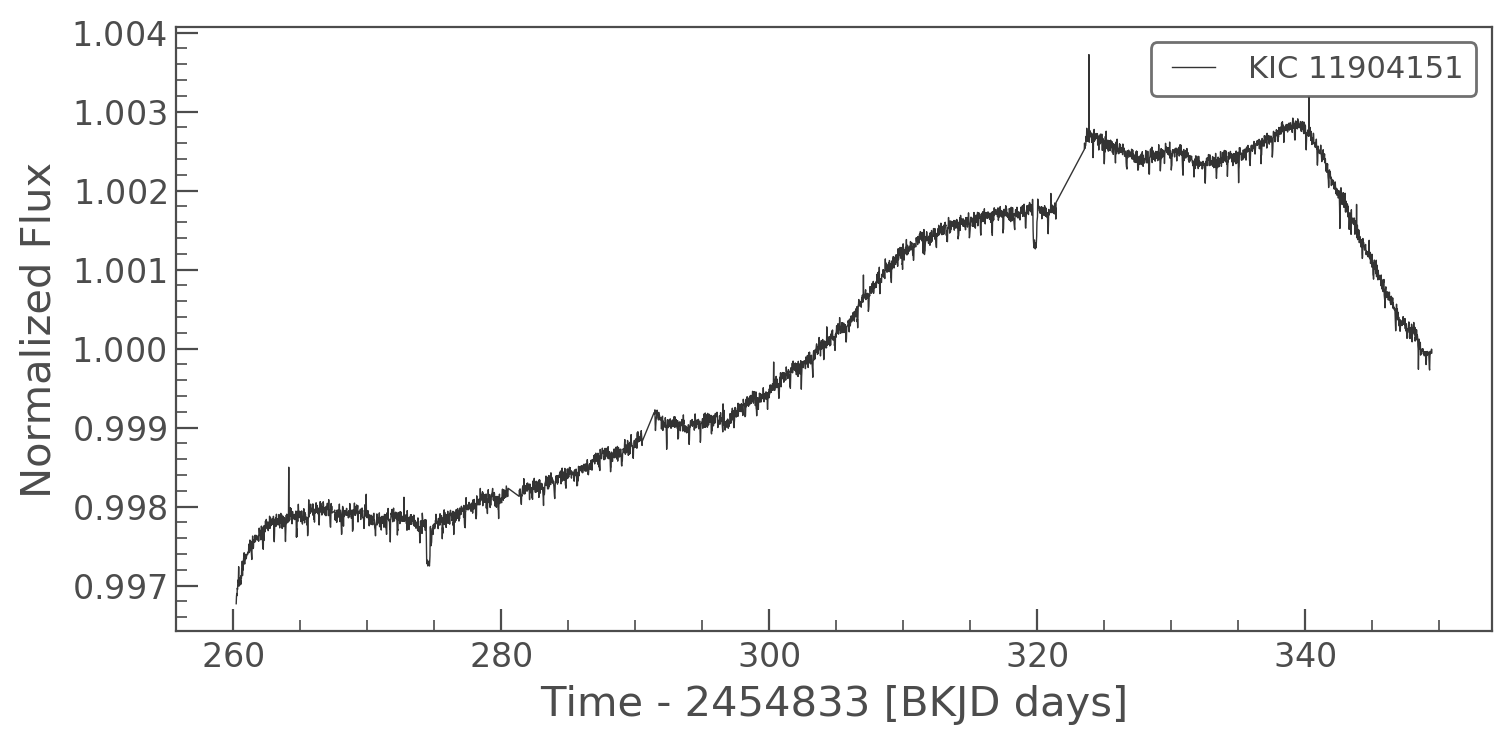

In [4]:
lc.plot();

Now let's use the `flatten` method, which applies a Savitzky-Golay filter, to remove long-term variability that we are not interested in. We'll use the `return_trend` keyword so that it returns both the corrected `KeplerLightCurve` object and a new `KeplerLightCurve` object called 'trend'. This contains only the long term variability.

In [5]:
flat, trend = lc.flatten(window_length=301, return_trend=True)

Let's plot the trend estimated by the Savitzky-Golay filter:

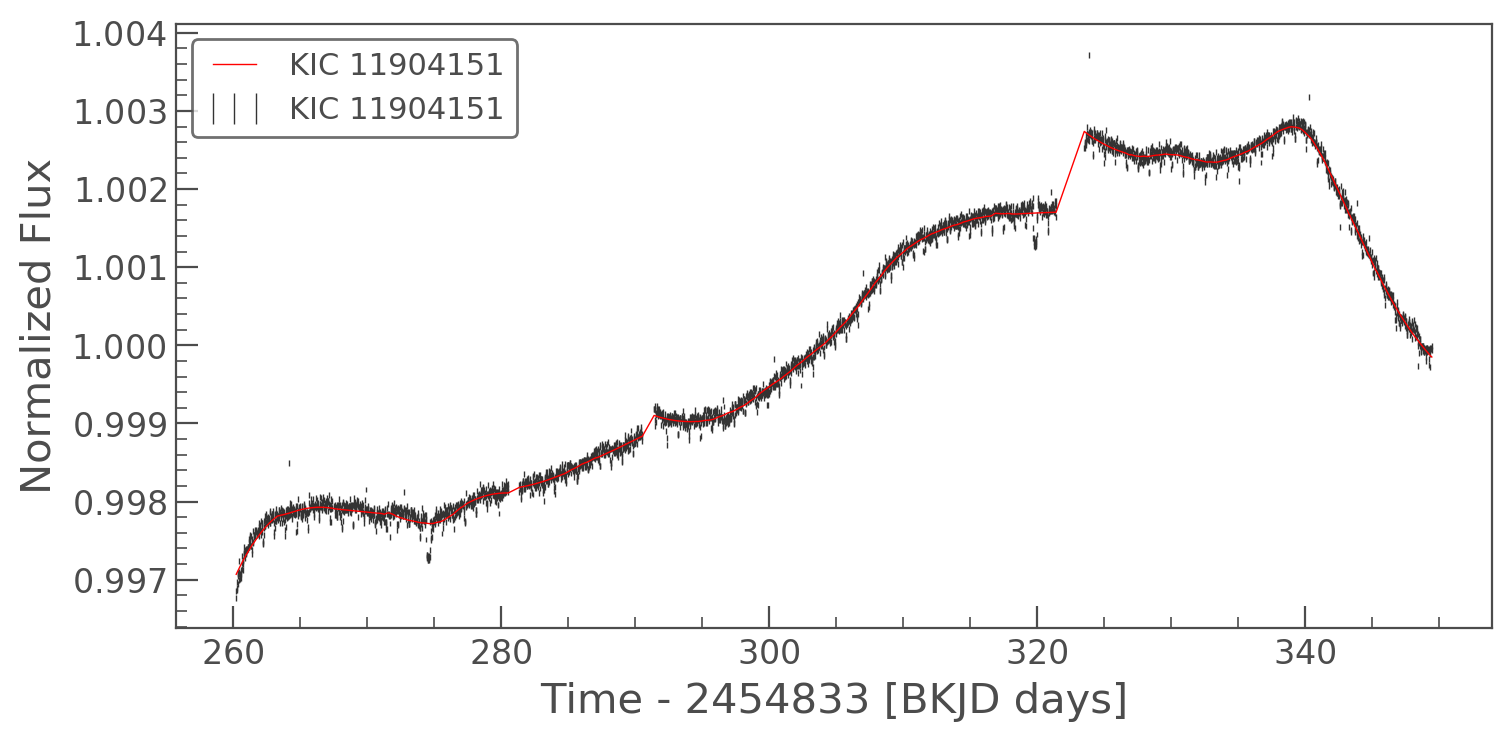

In [6]:
ax = lc.errorbar()                    # plot() returns a matplotlib axis 
trend.plot(ax=ax, color='red');       # which we can pass to the next plot() to use the same plotting window

and the flat lightcurve:

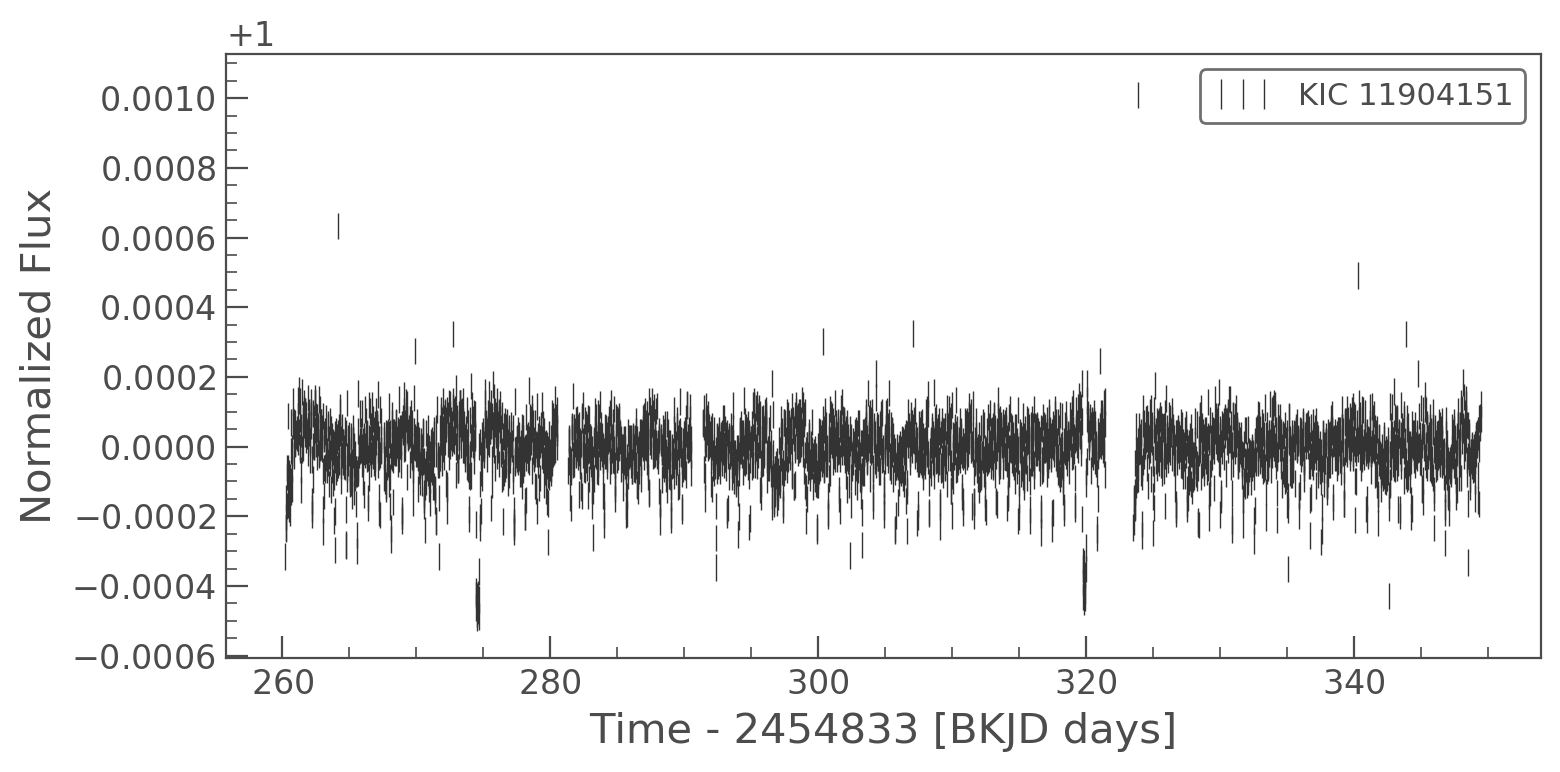

In [7]:
flat.errorbar();

Now, let's run a period search function using the Box-Least Squares algorithm (http://adsabs.harvard.edu/abs/2002A%26A...391..369K). We will shortly have a built in BLS implementation, but until then you can download and install it separately from lightkurve using

`pip install git+https://github.com/mirca/transit-periodogram.git`

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
periods = np.arange(0.3, 1.5, 0.0001)
durations = np.arange(0.005, 0.15, 0.001)

You can either use `astropy` or `transit_periodogram`.  The astropy version requires v3.1 or newer:  
http://docs.astropy.org/en/stable/whatsnew/3.1.html#whatsnew-3-1-transit-periodogram

In [10]:
#from transit_periodogram import transit_periodogram

#power, _, _, _, _, _, _ = transit_periodogram(time=flat.time, 
#                                              flux=flat.flux,
#                                              flux_err=flat.flux_err,
#                                              periods=periods, 
#                                              durations=durations)
#best_fit = periods[np.argmax(power)]

In [11]:
from astropy import units as u
from astropy.stats import BoxLeastSquares

In [12]:
model = BoxLeastSquares(flat.time, flat.flux, flat.flux_err)  

In [13]:
periodogram = model.power(periods, durations)  

In [14]:
best_fit = periods[np.argmax(periodogram.power)]

In [15]:
print('Best Fit Period: {:0.5f} days'.format(best_fit))

Best Fit Period: 0.83750 days


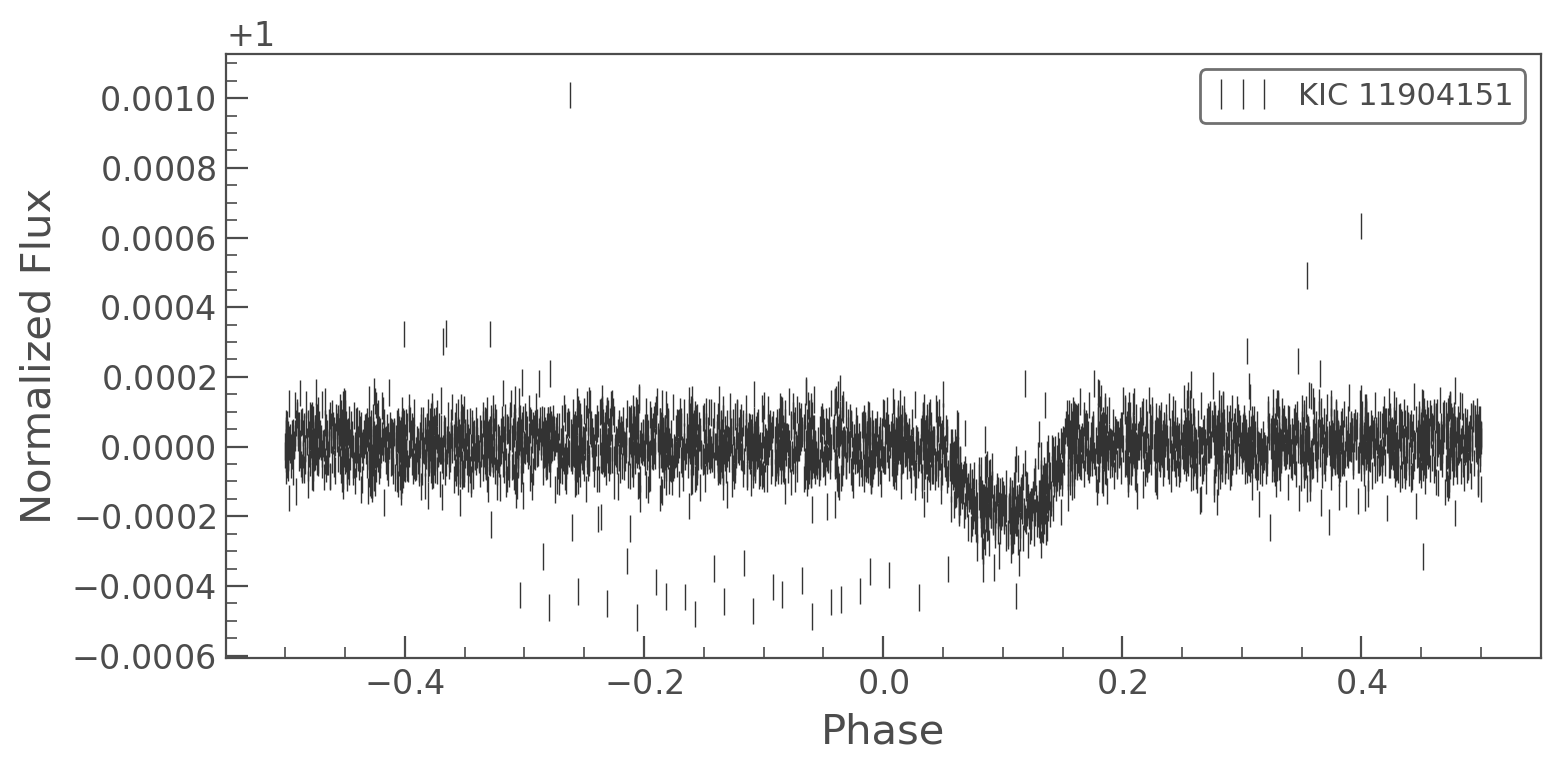

In [16]:
flat.fold(best_fit).errorbar();